In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy, get_roc_auc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/census/adult.csv")
data['income']=data['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})
data["sex"] = data["sex"].map({"Male": 0, "Female":1})

# Create Married Column - Binary Yes(1) or No(0)
data["marital.status"] = data["marital.status"].replace(['Never-married','Divorced','Separated','Widowed'], 'Single')
data["marital.status"] = data["marital.status"].replace(['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse'], 'Married')
data["marital.status"] = data["marital.status"].map({"Married":1, "Single":0})
data["marital.status"] = data["marital.status"].astype(int)

# Drop the data you don't want to use
data.drop(labels=["workclass","education","occupation","relationship","race","native.country"], axis = 1, inplace = True)
#data = data.drop(columns=[' Net Income Flag', ' Liability-Assets Flag'])
data.head()

,age,fnlwgt,education.num,marital.status,sex,capital.gain,capital.loss,hours.per.week,income
0,90,77053,9,0,1,0,4356,40,0
1,82,132870,9,0,1,0,4356,18,0
2,66,186061,10,0,1,0,4356,40,0
3,54,140359,4,0,1,0,3900,40,0
4,41,264663,10,0,1,0,3900,40,0


In [4]:
data.shape

(32561, 9)

In [5]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [6]:
target = 'income'

In [7]:
X = data.drop(columns=[target])
y = data[target]

In [8]:
#model_ctgan = CTGANSynthesizer(epochs=25)
#model_ctgan = DPCTGANSynthesizer(verbose=True)
model_ctgan = FPGANSynthesizer(verbose=True, epochs=25)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data, rate=0.25)

Epoch 1, Loss G: -0.2934,Loss D: -2.6074
Epoch 2, Loss G: -0.1120,Loss D: -2.0725
Epoch 3, Loss G: -0.3257,Loss D:  0.3008
Epoch 4, Loss G: -0.3230,Loss D: -0.3726
Epoch 5, Loss G: -0.2505,Loss D: -0.5026
Epoch 6, Loss G: -0.2462,Loss D: -0.6878
Epoch 7, Loss G: -0.2153,Loss D: -0.9175
Epoch 8, Loss G: -0.1970,Loss D: -1.1896
Epoch 9, Loss G: -0.1821,Loss D: -1.0658
Epoch 10, Loss G: -0.1722,Loss D: -1.6027
Epoch 11, Loss G: -0.2031,Loss D: -1.5104
Epoch 12, Loss G: -0.1716,Loss D: -1.8270
Epoch 13, Loss G: -0.1697,Loss D: -1.9604
Epoch 14, Loss G: -0.1427,Loss D: -2.1102
Epoch 15, Loss G: -0.1365,Loss D: -2.6447
Epoch 16, Loss G: -0.1210,Loss D: -2.5618
Epoch 17, Loss G: -0.1007,Loss D: -2.7108
Epoch 18, Loss G: -0.0983,Loss D: -2.9487
Epoch 19, Loss G: -0.1007,Loss D: -3.0107
Epoch 20, Loss G: -0.1111,Loss D: -2.7439
Epoch 21, Loss G: -0.1096,Loss D: -2.9326
Epoch 22, Loss G: -0.1060,Loss D: -2.9079
Epoch 23, Loss G: -0.1005,Loss D: -3.0170
Epoch 24, Loss G: -0.1131,Loss D: -2.7863
E

([array(0.00562558, dtype=float32),
  array(0.01037132, dtype=float32),
  array(0.01249134, dtype=float32),
  array(0.00820303, dtype=float32),
  array(0.01561042, dtype=float32),
  array(0.02258024, dtype=float32),
  array(0.02845648, dtype=float32),
  array(0.0308498, dtype=float32),
  array(0.04992761, dtype=float32),
  array(0.05456729, dtype=float32),
  array(0.07498698, dtype=float32),
  array(0.09287777, dtype=float32),
  array(0.11216917, dtype=float32),
  array(0.13526006, dtype=float32),
  array(0.18292059, dtype=float32),
  array(0.20555533, dtype=float32),
  array(0.2618802, dtype=float32),
  array(0.31520578, dtype=float32),
  array(0.3398966, dtype=float32),
  array(0.40808186, dtype=float32),
  array(0.44510877, dtype=float32),
  array(0.4995761, dtype=float32),
  array(0.5356473, dtype=float32),
  array(0.572029, dtype=float32),
  array(0.60851943, dtype=float32),
  array(0.6298476, dtype=float32),
  array(0.5759567, dtype=float32),
  array(0.60357517, dtype=float32),
 

In [9]:
from utils.utils import save_models
save_models(model_ctgan, '025fpgan25', 'census')

In [8]:
from utils.utils import load_models
model_ctgan = load_models('025fpgan25', 'census')

In [9]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [10]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [11]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.11780276]


## Fidelity

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

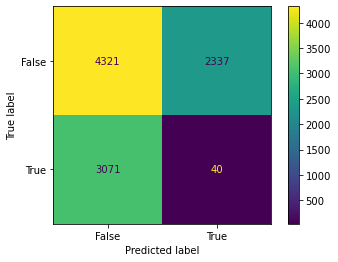

In [13]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [14]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [15]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.8176886068174839
Accuracy of synthetic data:  0.5429419592588801


In [16]:
rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.8057549179170118
ROC AUC of synthetic data:  0.3767197117487955


## Final plot

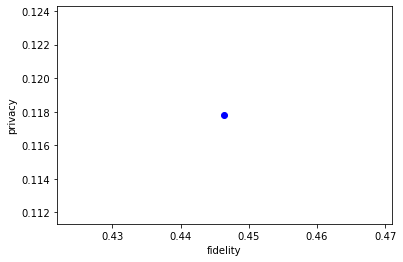

0.4464121199713379 [0.11780276]


In [17]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)